# Deep Learning & Generative AI

**Loading required Python Modules**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import random
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict
!pip install keras-tcn --quiet
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, Concatenate, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from tcn import TCN

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

from google.colab import files
uploaded = files.upload()


Saving online_retail_II.xlsx to online_retail_II.xlsx


**Loading the datasets**

In [ ]:
df_1 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df_2 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')
df = pd.concat([df_1, df_2])
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Preprocessing

**Understanding the data**

In [ ]:
df.shape

(1067371, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


In [ ]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,1.067371e+06,1067371,1.067371e+06,824364.000000
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00,15324.638504
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.727058e+02,NaN,1.235531e+02,1697.464450


In [ ]:
df.apply(lambda col: col.unique())

,0
Invoice,"[489434, 489435, 489436, 489437, 489438, 48943..."
StockCode,"[85048, 79323P, 79323W, 22041, 21232, 22064, 2..."
Description,"[15CM CHRISTMAS GLASS BALL 20 LIGHTS, PINK CHE..."
Quantity,"[12, 48, 24, 10, 18, 3, 16, 4, 2, 6, 8, 1, 28,..."
InvoiceDate,"[2009-12-01 07:45:00, 2009-12-01 07:46:00, 200..."
Price,"[6.95, 6.75, 2.1, 1.25, 1.65, 5.95, 2.55, 3.75..."
Customer ID,"[13085.0, 13078.0, 15362.0, 18102.0, 12682.0, ..."
Country,"[United Kingdom, France, USA, Belgium, Austral..."


In [ ]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

**Check Missing Values**

In [ ]:
df.isna().values.any()

np.True_

In [ ]:
df.isna().sum()

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0


**Missing Customer IDs**

In [ ]:
df.dropna(subset=['Customer ID'], inplace=True)
df['Customer ID'] = df['Customer ID'].astype(int)
df.isna().sum()

,0
Invoice,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
Price,0
Customer ID,0
Country,0


**Checking Cancelled Order**

In [ ]:
df['IsCancelled'] = df['Invoice'].apply(
    lambda l: str(l).startswith("C")
)
df['IsCancelled'].value_counts()

,count
IsCancelled,
False,805620
True,18744


In [ ]:
df[df['IsCancelled'] == True].describe()

,Quantity,InvoiceDate,Price,Customer ID
count,18744.000000,18744,18744.000000,18744.000000
mean,-25.970604,2010-12-11 12:47:12.506402048,23.899851,15014.418694
min,-80995.000000,2009-12-01 10:33:00,0.010000,12346.000000
25%,-6.000000,2010-06-07 09:52:00,1.450000,13552.000000
50%,-2.000000,2010-11-26 16:00:30,2.950000,14911.000000
75%,-1.000000,2011-06-29 13:29:00,5.950000,16401.000000
max,-1.000000,2011-12-09 11:58:00,38970.000000,18287.000000
std,821.040686,NaN,424.194716,1698.413277


In [ ]:
# All cancellations have negative quantites but positive, non-zero unit prices. All these occurances are dropped as they are hard to understand.
df = df[df['IsCancelled'] == False].copy()
df = df.drop('IsCancelled', axis=1)

**Checking Price**

In [ ]:
df['Price'].describe()

,Price
count,805620.000000
mean,3.206279
std,29.197901
min,0.000000
25%,1.250000
50%,1.950000
75%,3.750000
max,10953.500000


In [ ]:
df[df['Price'] == 0].sort_values(by='Quantity', ascending=False).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256,United Kingdom
358820,524181,46000M,POLYESTER FILLER PAD 45x45cm,648,2010-09-27 16:59:00,0.0,17450,United Kingdom
298054,562973,23157,SET OF 6 NATIVITY MAGNETS,240,2011-08-11 11:42:00,0.0,14911,EIRE
436428,574138,23234,BISCUIT TIN VINTAGE CHRISTMAS,216,2011-11-03 11:26:00,0.0,12415,Australia
314746,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,2011-08-26 14:19:00,0.0,14646,Netherlands


In [ ]:
df = df[df['Price'] > 0].copy()

**Removing Test Product**

In [ ]:
df[df['StockCode'].str.startswith('TEST', na=False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.5,12346,United Kingdom
28251,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4.5,12346,United Kingdom
28254,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.5,12346,United Kingdom
39398,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,4.5,12346,United Kingdom
39411,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.0,12346,United Kingdom
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.5,12346,United Kingdom
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.5,12346,United Kingdom
56117,494450,TEST001,This is a test product.,5,2010-01-14 13:50:00,4.5,12346,United Kingdom
66084,495295,TEST001,This is a test product.,5,2010-01-22 13:30:00,4.5,12346,United Kingdom
156017,504188,TEST001,This is a test product.,5,2010-04-12 09:52:00,4.5,16454,United Kingdom


In [ ]:
df = df[~df['StockCode'].str.startswith('TEST', na=False)]

### Feature Engineering

**Total Amount Spent**

In [ ]:
df['TotalSales'] = df['Quantity'] * df['Price']

**Parse Dates & Sort by Customer + Time**

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
# Sort for sequential modeling
df = df.sort_values(by=['Customer ID', 'InvoiceDate']).reset_index(drop=True)

# EDA

**Number of transactions per customer**

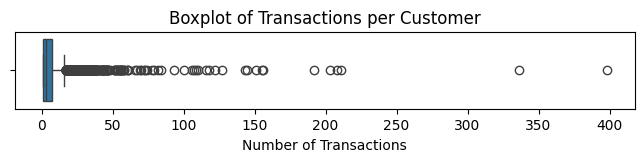

In [ ]:

purchase_counts = df.groupby('Customer ID')['Invoice'].nunique().sort_values(ascending=False)
plt.figure(figsize=(8, 1))
sns.boxplot(x=purchase_counts)
plt.title("Boxplot of Transactions per Customer")
plt.xlabel("Number of Transactions")
plt.show()

**Time Between Purchases (Sequence Gap)**

count    799661.000000
mean          1.992109
std          17.922930
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         714.000000
Name: DaysUntilNext, dtype: float64


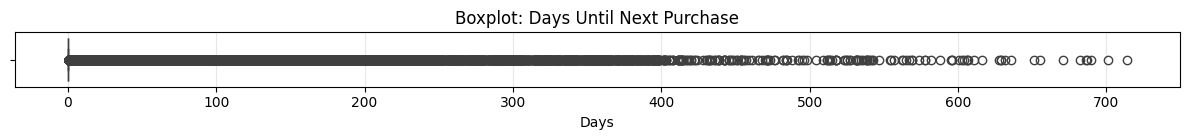

In [ ]:
# Create a new column with the next purchase timestamp
df['NextPurchaseDate'] = df.groupby('Customer ID')['InvoiceDate'].shift(-1)

# Time difference (in days) between current and next purchase
df['DaysUntilNext'] = (df['NextPurchaseDate'] - df['InvoiceDate']).dt.days

# Summary stats
print(df['DaysUntilNext'].describe())

plt.figure(figsize=(12, 1.5))
sns.boxplot(x=df['DaysUntilNext'].dropna())
plt.title("Boxplot: Days Until Next Purchase")
plt.xlabel("Days")
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**Total Sales Over Time (Monthly)**

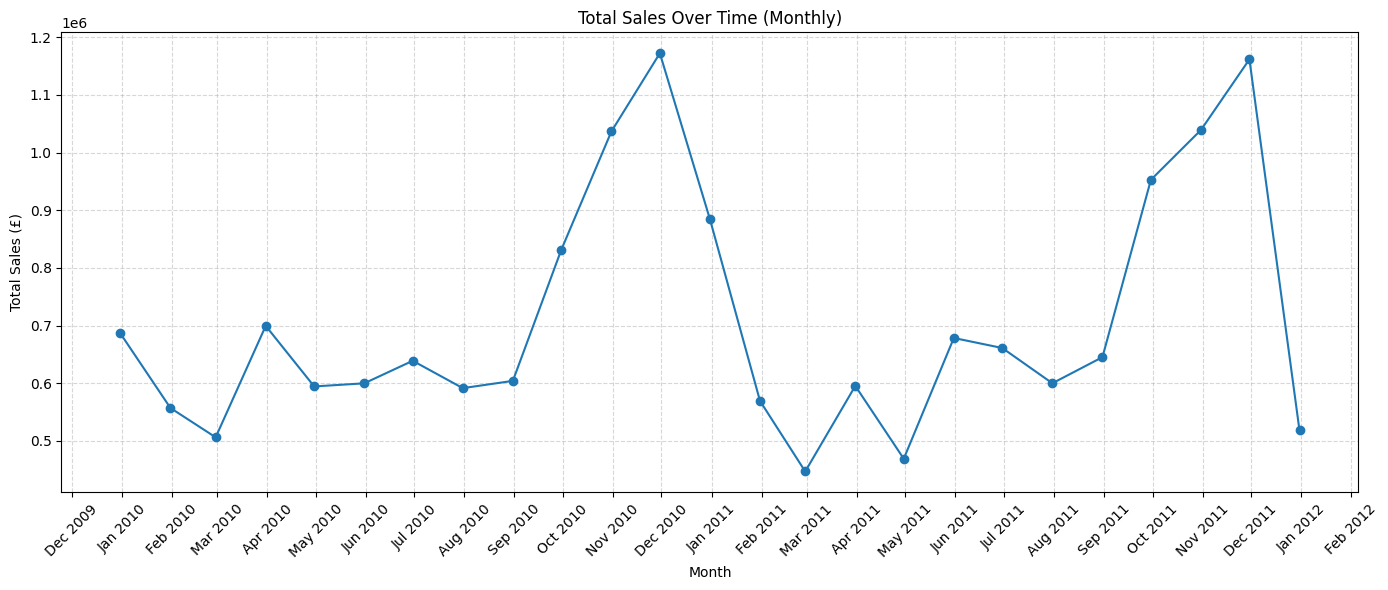

In [ ]:
df.set_index('InvoiceDate', inplace=True)
monthly_sales = df['TotalSales'].resample('M').sum()

plt.figure(figsize=(14, 6))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o')

# Format the x-axis to show every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)
plt.title("Total Sales Over Time (Monthly)")
plt.xlabel("Month")
plt.ylabel("Total Sales (£)")
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

df.reset_index(inplace=True)

**Average Transaction Value & Quantity per Invoice**

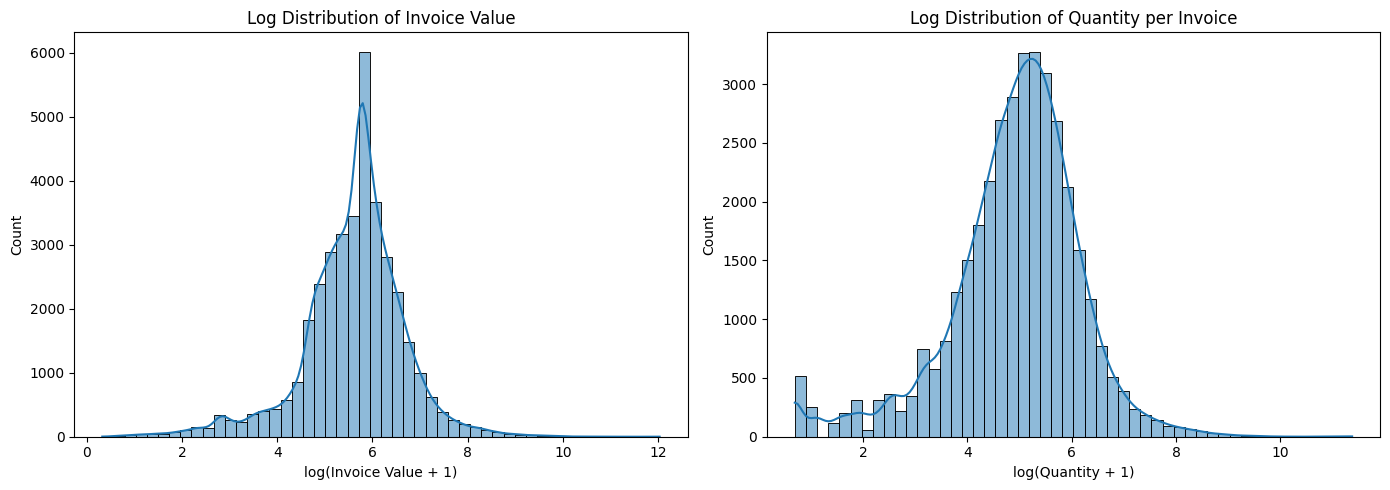

In [ ]:
# Total per Invoice
invoice_data = df.groupby('Invoice').agg({
    'TotalSales': 'sum',
    'Quantity': 'sum'
}).rename(columns={'TotalSales': 'InvoiceValue', 'Quantity': 'TotalQuantity'})

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(np.log1p(invoice_data['InvoiceValue']), bins=50, kde=True)
plt.title('Log Distribution of Invoice Value')
plt.xlabel('log(Invoice Value + 1)')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(invoice_data['TotalQuantity']), bins=50, kde=True)
plt.title('Log Distribution of Quantity per Invoice')
plt.xlabel('log(Quantity + 1)')

plt.tight_layout()
plt.show()

**Country-Level Sales Analysis**

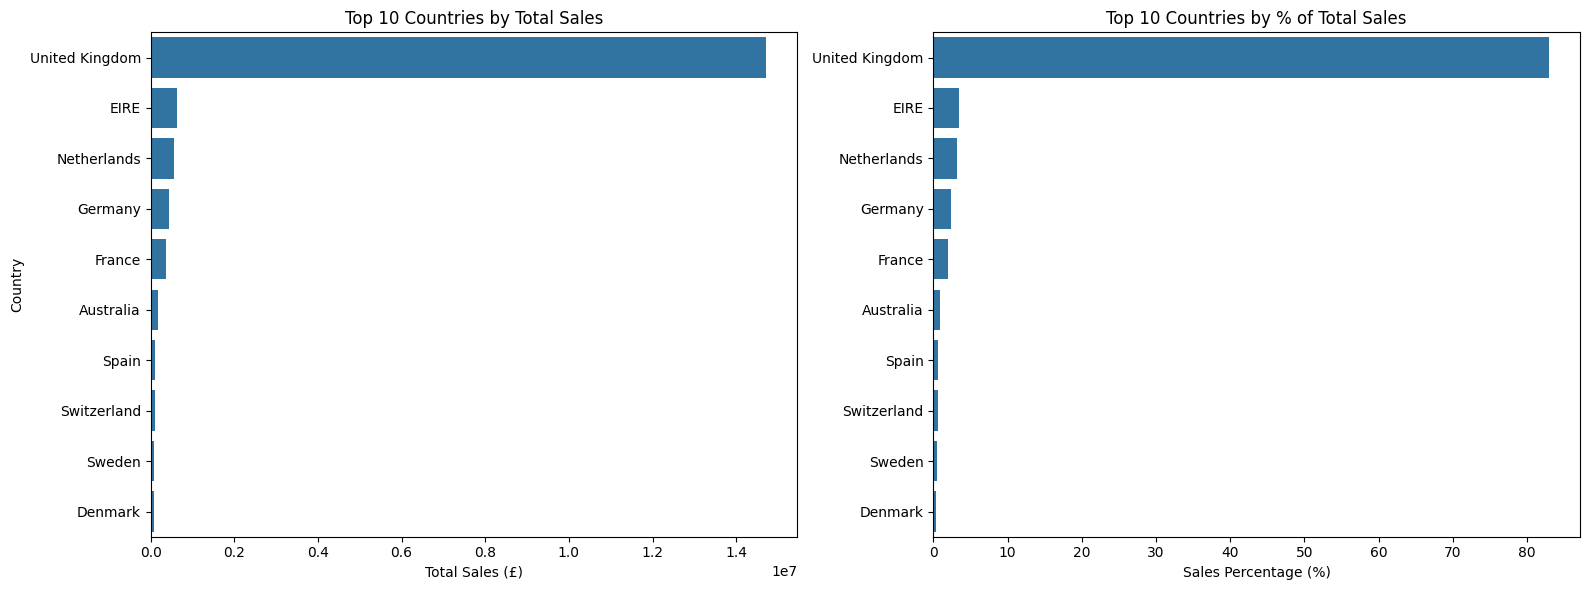

In [ ]:
country_sales = df.groupby('Country')['TotalSales'].sum().sort_values(ascending=False)
sales_pct = (country_sales / country_sales.sum()) * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Total Sales Bar Chart
sns.barplot(x=country_sales.head(10).values, y=country_sales.head(10).index, ax=axes[0])
axes[0].set_title("Top 10 Countries by Total Sales")
axes[0].set_xlabel("Total Sales (£)")
axes[0].set_ylabel("Country")
axes[0].grid(False)

# Sales Percentage Bar Chart
sns.barplot(x=sales_pct.head(10).values, y=sales_pct.head(10).index, ax=axes[1])
axes[1].set_title("Top 10 Countries by % of Total Sales")
axes[1].set_xlabel("Sales Percentage (%)")
axes[1].set_ylabel("")
axes[1].grid(False)

plt.tight_layout()
plt.show()

# Transforming

**Filters only active customers (≥6 purchases)**

In [ ]:
df.head()

,InvoiceDate,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,TotalSales,NextPurchaseDate,DaysUntilNext
0,2010-03-02 13:08:00,499763,20682,RED SPOTTY CHILDS UMBRELLA,1,3.25,12346,United Kingdom,3.25,2010-03-02 13:08:00,0.0
1,2010-03-02 13:08:00,499763,20679,EDWARDIAN PARASOL RED,1,5.95,12346,United Kingdom,5.95,2010-03-02 13:08:00,0.0
2,2010-03-02 13:08:00,499763,15056N,EDWARDIAN PARASOL NATURAL,1,5.95,12346,United Kingdom,5.95,2010-03-02 13:08:00,0.0
3,2010-03-02 13:08:00,499763,15056BL,EDWARDIAN PARASOL BLACK,1,5.95,12346,United Kingdom,5.95,2010-03-02 13:08:00,0.0
4,2010-03-02 13:08:00,499763,15056P,EDWARDIAN PARASOL PINK,1,5.95,12346,United Kingdom,5.95,2010-06-28 13:53:00,118.0


In [ ]:
# Filter customers with at least 6 purchases (to get one y after a sequence of 5)
customer_purchase_counts = df.groupby('Customer ID')['Invoice'].nunique()
eligible_customers = customer_purchase_counts[customer_purchase_counts >= 6].index

df_filtered = df[df['Customer ID'].isin(eligible_customers)].copy()
df_filtered = df_filtered.sort_values(by=['Customer ID', 'InvoiceDate'])

# Recompute DaysUntilNext (in case of prior steps)
df_filtered['NextPurchaseDate'] = df_filtered.groupby('Customer ID')['InvoiceDate'].shift(-1)
df_filtered['DaysUntilNext'] = (df_filtered['NextPurchaseDate'] - df_filtered['InvoiceDate']).dt.days

# Build sequences
sequence_length = 5
X, y = [], []

for customer_id, group in df_filtered.groupby('Customer ID'):
    days_sequence = group['DaysUntilNext'].dropna().tolist()
    if len(days_sequence) > sequence_length:
        for i in range(len(days_sequence) - sequence_length):
            seq_x = days_sequence[i:i+sequence_length]
            seq_y = days_sequence[i+sequence_length]
            X.append(seq_x)
            y.append(seq_y)

X = np.array(X)
y = np.array(y)

X.shape, y.shape

((590189, 5), (590189,))

**Remove Outliers**

In [ ]:
threshold = df_filtered['DaysUntilNext'].quantile(0.99) # Clipping extreme outliers based on EDA (long gaps beyond 99th percentile)
print(f"99th percentile threshold: {threshold:.2f} days")

99th percentile threshold: 51.00 days


In [ ]:
df_filtered = df_filtered[df_filtered['DaysUntilNext'] <= threshold]

**Build Time-Based Sequences Per Customer**

In [ ]:
sequence_length = 5
X, y = [], []

for customer_id, group in df_filtered.groupby('Customer ID'):
    days_sequence = group['DaysUntilNext'].dropna().tolist()
    if len(days_sequence) > sequence_length:
        for i in range(len(days_sequence) - sequence_length):
            seq_x = days_sequence[i:i+sequence_length]
            seq_y = days_sequence[i+sequence_length]
            X.append(seq_x)
            y.append(seq_y)

X = np.array(X)
y = np.array(y)

X.shape, y.shape

((584294, 5), (584294,))

**Reshape Data for LSTM/TCN Input Format**

In [ ]:
X = X.reshape((X.shape[0], X.shape[1], 1))

**Train-Test Split (Sequential — No Shuffling)**

In [ ]:
#no shuffle to preserve order
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

**Log Transform Target Variable**

In [ ]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

**Scaling Phase**

In [ ]:
# Flatten X for scaling
X_train_flat = X_train.reshape(-1, 1)
X_test_flat = X_test.reshape(-1, 1)

# Fit scaler on combined input and log-transformed target
scaler = MinMaxScaler()
scaler.fit(np.concatenate((X_train_flat, y_train_log.reshape(-1, 1)), axis=0))

# Scale inputs
X_train = scaler.transform(X_train_flat).reshape(X_train.shape)
X_test = scaler.transform(X_test_flat).reshape(X_test.shape)

# Scale log-transformed targets
y_train = scaler.transform(y_train_log.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test_log.reshape(-1, 1)).flatten()

# Model Implementation

**Model Evaluation & Visualization Function**

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=128):
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    return model, history

model_scores = {}
def evaluate_model(model, X_test, y_test, scaler=None, log_transformed=True, label="", plot_samples=100):
    import numpy as np
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
    import matplotlib.pyplot as plt

    y_pred = model.predict(X_test)

    if scaler and log_transformed:
        y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_scaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_orig = np.expm1(y_test_scaled)
        y_pred_orig = np.expm1(y_pred_scaled)
    else:
        y_test_orig = y_test
        y_pred_orig = y_pred.flatten()

    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    med_ae = median_absolute_error(y_test_orig, y_pred_orig)

    model_scores[label] = {
        "MAE": mae,
        "RMSE": rmse,
        "MedianAE": med_ae
    }

    print(f"{label} → MAE: {mae:.4f}, RMSE: {rmse:.4f}, MedianAE: {med_ae:.4f}")

    return

In [ ]:
# Define Input Shape for Sequential Models
input_shape = (X_train.shape[1], X_train.shape[2])

**LSTM Model**

In [ ]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# LSTM
lstm_model = build_lstm_model(input_shape)
lstm_model.summary()
train_model(lstm_model, X_train, y_train, X_test, y_test, epochs=20, batch_size=128)
evaluate_model(lstm_model, X_test, y_test, scaler=scaler, label="LSTM")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 58s 15ms/step - loss: 8.5976e-05 - mae: 0.0030 - val_loss: 8.2492e-05 - val_mae: 0.0026
Epoch 2/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - loss: 8.4834e-05 - mae: 0.0029 - val_loss: 8.2524e-05 - val_mae: 0.0025
Epoch 3/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 52s 14ms/step - loss: 8.4837e-05 - mae: 0.0029 - val_loss: 8.2522e-05 - val_mae: 0.0025
Epoch 4/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - loss: 8.4830e-05 - mae: 0.0029 - val_loss: 8.2505e-05 - val_mae: 0.0025
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
LSTM → MAE: 0.5856, RMSE: 3.9518, MedianAE: 0.0614


**CNN Model**

In [ ]:
def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# CNN
cnn_model = build_cnn_model(input_shape)
cnn_model.summary()
train_model(cnn_model, X_train, y_train, X_test, y_test, epochs=20, batch_size=128)
evaluate_model(cnn_model, X_test, y_test, scaler=scaler, label="CNN")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 3, 64)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,481 (17.50 KB)

 Trainable params: 4,481 (17.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 8.8976e-05 - mae: 0.0030 - val_loss: 8.2528e-05 - val_mae: 0.0025
Epoch 2/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 8.4824e-05 - mae: 0.0029 - val_loss: 8.2531e-05 - val_mae: 0.0025
Epoch 3/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 8.4822e-05 - mae: 0.0029 - val_loss: 8.2531e-05 - val_mae: 0.0025
Epoch 4/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 8.4828e-05 - mae: 0.0029 - val_loss: 8.2532e-05 - val_mae: 0.0025
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
CNN → MAE: 0.5824, RMSE: 3.9522, MedianAE: 0.0580


**TCN Model**

In [ ]:
def build_tcn_model(input_shape):
    model = Sequential([
        TCN(input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# TCN
tcn_model = build_tcn_model(input_shape)
tcn_model.summary()
train_model(tcn_model, X_train, y_train, X_test, y_test, epochs=20, batch_size=128)
evaluate_model(tcn_model, X_test, y_test, scaler=scaler, label="TCN")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ tcn (TCN)                            │ (None, 64)                  │         136,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,321 (532.50 KB)

 Trainable params: 136,321 (532.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 314s 84ms/step - loss: 0.0013 - mae: 0.0070 - val_loss: 1.0302e-04 - val_mae: 0.0042
Epoch 2/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 313s 86ms/step - loss: 1.0899e-04 - mae: 0.0039 - val_loss: 8.4490e-05 - val_mae: 0.0026
Epoch 3/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 308s 84ms/step - loss: 9.3242e-05 - mae: 0.0035 - val_loss: 8.5450e-05 - val_mae: 0.0019
Epoch 4/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 325s 85ms/step - loss: 8.7025e-05 - mae: 0.0031 - val_loss: 8.3043e-05 - val_mae: 0.0036
Epoch 5/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 322s 86ms/step - loss: 8.5324e-05 - mae: 0.0029 - val_loss: 8.2369e-05 - val_mae: 0.0027
Epoch 6/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 323s 86ms/step - loss: 8.4852e-05 - mae: 0.0029 - val_loss: 8.2446e-05 - val_mae: 0.0025
Epoch 7/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 322s 86ms/step - loss: 8.4803e-05 - mae: 0.0029 - val_loss: 8.2494e-05 - val_mae: 0.0025
Epoch 8/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 317s 84ms/step - loss: 8.4811e-05 - mae: 0.00

**CNN + TCN Hybrid Model**

In [ ]:
def build_cnn_tcn_model(input_shape):
    input_layer = Input(shape=input_shape)

    # Simplified CNN branch
    cnn_branch = Conv1D(32, kernel_size=3, activation='relu')(input_layer)
    cnn_branch = GlobalAveragePooling1D()(cnn_branch)

    # Simplified TCN branch
    tcn_branch = TCN(nb_filters=32, dilations=[1, 2, 4], dropout_rate=0.1)(input_layer)

    # Combine
    concat = Concatenate()([cnn_branch, tcn_branch])
    dense = Dense(32, activation='relu')(concat)
    output = Dense(1)(dense)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# CNN + TCN Hybrid
cnn_tcn_model = build_cnn_tcn_model(input_shape)
cnn_tcn_model.summary()
train_model(cnn_tcn_model, X_train, y_train, X_test, y_test, epochs=20, batch_size=128)
evaluate_model(cnn_tcn_model, X_test, y_test, scaler=scaler, label="CNN + TCN")

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 5, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 3, 32)          │            128 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 32)             │              0 │ conv1d_1[0][0]         │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tcn_1 (TCN)               │ (None, 32)             │         15,712 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64)             │              0 │ global_average_poolin… │
│                           │                        │                │ tcn_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │          2,080 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │             33 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 17,953 (70.13 KB)

 Trainable params: 17,953 (70.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 56s 14ms/step - loss: 1.8318e-04 - mae: 0.0042 - val_loss: 8.2422e-05 - val_mae: 0.0030
Epoch 2/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - loss: 8.5172e-05 - mae: 0.0029 - val_loss: 8.2407e-05 - val_mae: 0.0025
Epoch 3/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - loss: 8.4859e-05 - mae: 0.0029 - val_loss: 8.2455e-05 - val_mae: 0.0025
Epoch 4/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - loss: 8.4811e-05 - mae: 0.0029 - val_loss: 8.2497e-05 - val_mae: 0.0025
Epoch 5/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - loss: 8.4813e-05 - mae: 0.0029 - val_loss: 8.2471e-05 - val_mae: 0.0025
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
CNN + TCN → MAE: 0.5849, RMSE: 3.9515, MedianAE: 0.0585


**CNN + LSTM Hybrid Model**

In [ ]:
def build_cnn_lstm_model(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=2, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# CNN + LSTM Hybrid
cnn_lstm_model = build_cnn_lstm_model(input_shape)
cnn_lstm_model.summary()
train_model(cnn_lstm_model, X_train, y_train, X_test, y_test, epochs=20, batch_size=128)
evaluate_model(cnn_lstm_model, X_test, y_test, scaler=scaler, label="CNN + LSTM")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 4, 32)               │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          16,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,747 (65.42 KB)

 Trainable params: 16,747 (65.42 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 8.5024e-05 - mae: 0.0029 - val_loss: 8.2494e-05 - val_mae: 0.0025
Epoch 2/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 8.4818e-05 - mae: 0.0029 - val_loss: 8.2508e-05 - val_mae: 0.0025
Epoch 3/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 8.4807e-05 - mae: 0.0029 - val_loss: 8.2504e-05 - val_mae: 0.0025
Epoch 4/20
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 8.4798e-05 - mae: 0.0029 - val_loss: 8.2503e-05 - val_mae: 0.0025
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
CNN + LSTM → MAE: 0.5832, RMSE: 3.9520, MedianAE: 0.0587


**Model Comparison**

,Model,MAE,RMSE,MedianAE
1,CNN,0.5824,3.9522,0.0580
4,CNN + LSTM,0.5832,3.9520,0.0587
3,CNN + TCN,0.5849,3.9515,0.0585
0,LSTM,0.5856,3.9518,0.0614
2,TCN,0.5950,3.9503,0.0707


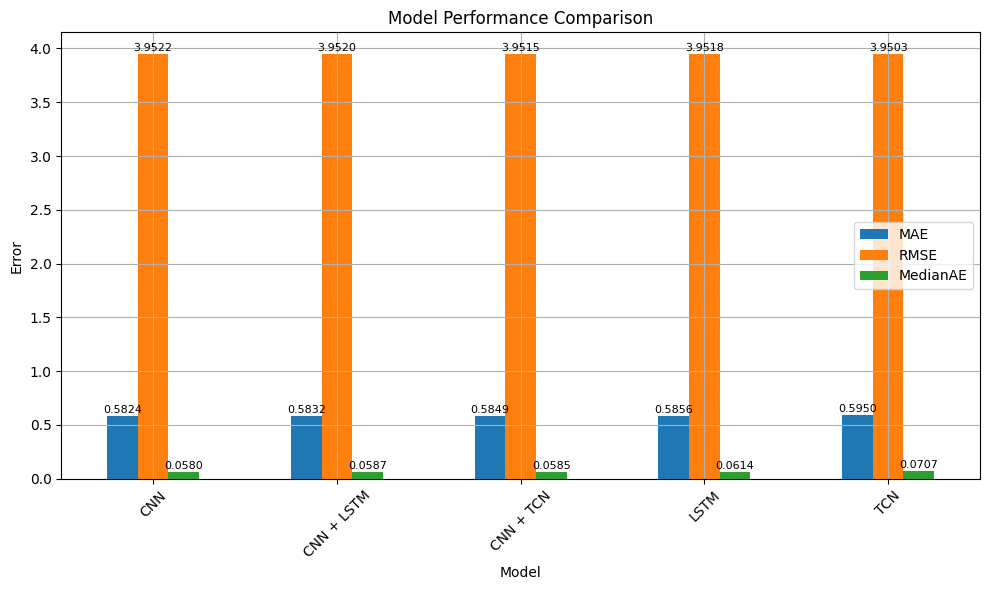

In [ ]:
df_results = pd.DataFrame(model_scores).T.reset_index().rename(columns={"index": "Model"})
df_results = df_results.sort_values(by="MAE", ascending=True)

display(
    df_results.style
        .highlight_min(color='lightgreen', subset=['MAE', 'RMSE', 'MedianAE'])
        .format(precision=4)
)

ax = df_results.set_index('Model')[['MAE', 'RMSE', 'MedianAE']].plot(kind='bar', figsize=(10, 6), grid=True)
plt.title("Model Performance Comparison")
plt.ylabel("Error")
plt.xticks(rotation=45)
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2., height + 0.01,
        f'{height:.4f}', ha='center', va='bottom', fontsize=8
    )

plt.show()